In [1]:
import os
import random
import cv2
import time
from IPython.display import HTML
from IPython.display import clear_output
from pathlib import Path

import numpy as np
import gym
import gym.wrappers
from gym.core import ObservationWrapper
from gym.spaces import Box
import torch
import torch.nn as nn
from tqdm import trange

import utils
from framebuffer import FrameBuffer
from replay_buffer import ReplayBuffer
import atari_wrappers
from experience_replay_buffer import ExperienceReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
ENV_NAME = "BreakoutNoFrameskip-v4"
PARAMS =  {'is_dueling':False, 'is_distributional':False, 'is_noisy': False, 'is_double': False}

USE_PRIORITIEZED_BUFFER = True

seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

REPLAY_BUFFER_SIZE = 3 * 10 ** 4
N_STEPS = 1000

timesteps_per_epoch = 1

batch_size = 16
total_steps = 10 ** 6
decay_steps = 7 * 10 ** 5

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [3]:
class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return rgb @ np.array(channel_weights)

    def observation(self, img):
        return np.expand_dims(cv2.resize(self._to_gray_scale(img)[25:201, :], self.img_size[1:]).astype(np.float32) / 255, axis=0)


def PrimaryAtariWrap(env, clip_rewards=True):
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.EpisodicLifeEnv(env)
    env = atari_wrappers.FireResetEnv(env)
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)
    env = PreprocessAtariObs(env)
    return env


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
class Noisy_layer(nn.Module):
    def __init__(self, input, output, sigma = 0.5):
        super().__init__()
        self.sigma  = sigma
        self.input  = input
        self.output = output

        self.mu_bias        = nn.Parameter(torch.FloatTensor(output))
        self.mu_weight      = nn.Parameter(torch.FloatTensor(output, input))
        self.sigma_bias     = nn.Parameter(torch.FloatTensor(output))
        self.sigma_weight   = nn.Parameter(torch.FloatTensor(output, input))

        self.bound = input ** (-0.5)
        self.mu_bias.data.uniform_(-self.bound, self.bound)
        self.sigma_bias.data.fill_(self.sigma * self.bound)
        self.mu_weight.data.uniform_(-self.bound, self.bound)
        self.sigma_weight.data.fill_(self.sigma * self.bound)

        self.epsilon_input  = self.get_noise(self.input)
        self.epsilon_output = self.get_noise(self.output)
    
    def get_noise(self, features):
        noise = torch.FloatTensor(features).uniform_(-self.bound, self.bound).to(self.mu_bias.device)
        return torch.sign(noise) * torch.sqrt(torch.abs(noise))
    
    def forward(self, x, sample_noise = True):
        if not self.training:
            return nn.functional.linear(x, weight = self.mu_weight, bias = self.mu_bias)

        if sample_noise:
            self.epsilon_input = self.get_noise(self.input)
            self.epsilon_output = self.get_noise(self.output)

        weight = self.sigma_weight * torch.ger(self.epsilon_output, self.epsilon_input) + self.mu_weight
        bias = self.sigma_bias * self.epsilon_output + self.mu_bias
        return nn.functional.linear(x, weight = weight, bias = bias)

In [6]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0, 
                 is_dueling=False, is_distributional=False, is_noisy=False, is_double=False, distribution_len = 15):
        super().__init__()
        
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.output = n_actions * (1 + (distribution_len - 1) * is_distributional) + is_dueling
        self.is_dueling         = is_dueling
        self.is_distributional  = is_distributional
        self.is_noisy           = is_noisy
        self.is_double          = is_double
        self.distribution_len = distribution_len
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=self.state_shape[0], out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        if is_noisy:
            self.dense_layers = nn.Sequential(
                Noisy_layer(64 * 7 * 7, 256),
                nn.ReLU(),
                Noisy_layer(256, self.output)
            )
        else:
            self.dense_layers = nn.Sequential(
                nn.Linear(64 * 7 * 7, 256),
                nn.ReLU(),
                nn.Linear(256, self.output)
            )

    def forward(self, state_t):
        model_device = next(self.parameters()).device
        if self.is_distributional:
            state_t = torch.tensor(state_t, device=model_device, dtype=torch.float32)
            batch_size = state_t.shape[0]         
            result = self.dense_layers(self.conv_layers(state_t))

            v_value, advantage = result[:, 0], result[:, 1:]

            advantage = advantage.reshape(batch_size, self.n_actions, self.distribution_len)

            advantage = advantage - torch.mean(advantage, dim=(1, 2))[:, None, None]
            distribution = v_value[:, None, None] + advantage
            distribution = distribution.reshape(batch_size, self.n_actions, self.distribution_len)

            return distribution
        
        if self.is_dueling:
            pre_result = self.dense_layers(self.conv_layers(state_t))
            v_value = pre_result[:, 0]
            advantage = pre_result[:, 1:]
            advantage = advantage - torch.mean(advantage, axis=1)[:, None]
            qvalues = advantage + v_value[:, None]
        else:
            qvalues = self.dense_layers(self.conv_layers(state_t))

        return qvalues
    
    def get_z_values(self, states):
        distribution = self.forward(states)
        return distribution

    def get_qvalues(self, states=None, zvalues=None):
        if self.is_distributional:
            if zvalues is None:
                distributions = self.get_z_values(states)
            else:
                distributions = zvalues
            qvalues = distributions.mean(-1)
        else:
            model_device = next(self.parameters()).device
            states = torch.tensor(states, device=model_device, dtype=torch.float32)
            qvalues = self.forward(states)
        
        return qvalues.data.cpu().numpy()


    def sample_actions(self, qvalues, use_epsilon=True):
        epsilon = self.epsilon if use_epsilon else 0
        
        if len(qvalues.shape) == 1:
            batch_size = 1
            n_actions = len(qvalues)
        else:
            batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [8]:
def play_and_record(initial_state, agent, target_network, env, exp_replay, n_steps=1, gamma=.99, is_priority=USE_PRIORITIEZED_BUFFER):
    s = initial_state
    sum_rewards = 0

    qvalues = agent.get_qvalues([s])
    
    for _ in range(n_steps):
        a = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(a)
        
        if is_priority:
            q_s_a = qvalues[0, a]
        
        qvalues = agent.get_qvalues([next_s])
        
        if is_priority:
            next_a = agent.sample_actions(qvalues[0], use_epsilon=False)
            delta = np.abs(q_s_a - (r + (1 - done) * gamma * target_network.get_qvalues([next_s])[0, next_a]))
            exp_replay.add(s, a, r, next_s, done, delta)
        else:
            exp_replay.add(s, a, r, next_s, done)

        s = next_s 
        
        if done:
            env.reset()
    
    return sum_rewards, s

In [9]:
kappa = 10

def huber_estimator(u):
    squerred = 1 / 2 * u ** 2
    otherwise = kappa * (torch.abs(u) - kappa / 2)
    return torch.where(torch.abs(u) <= kappa, squerred, otherwise)

def rho(u, tau):
    indicator = (u < 0).float()
    return huber_estimator(u) * torch.abs(tau - indicator) 

def compute_loss(pred, target, weights=None):
    N = pred.shape[1] 
    tau = (torch.arange(N, device=device) / N + 1 / (2 * N))
    batch_size = pred.shape[0]
    
    diff_tensor = torch.zeros((batch_size, N, N), device=device)
    
    diff_tensor = target.unsqueeze(2) - pred[:, None]
    if weights is None:
        loss = rho(diff_tensor, tau[None, :, None]).sum() / N
    else:
        loss = (weights * rho(diff_tensor, tau[None, :, None]).sum((1, 2))).sum() / N  
    return loss

def compute_td_loss(states, actions, rewards, next_states, is_done, weights=None,
                    agent=None, target_network=None,
                    gamma=0.99,
                    device=device):
    states = torch.tensor(states, device=device, dtype=torch.float32)
    actions = torch.tensor(actions, device=device, dtype=torch.int64)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)
    weights = torch.tensor(rewards, device=device, dtype=torch.float32).detach() if weights is not None else None
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )
    is_not_done = 1 - is_done
    
    
    if agent.is_distributional:
        predicted_z_values = agent.get_z_values(states)
        predicted_q_values = agent.get_qvalues(next_states)
        predicted_next_action = np.argmax(predicted_q_values, 1) 
        predicted_zvalues_for_actions = predicted_z_values[range(len(actions)), actions, :]

        target_next_z_values = target_network.get_z_values(next_states)
        target_next_z_values_for_action = target_next_z_values[range(len(actions)), predicted_next_action, :]
        target = rewards[:, None] + gamma * target_next_z_values_for_action * is_not_done[:, None]

        loss = compute_loss(predicted_zvalues_for_actions, target.detach(), weights)
        return loss
    
    predicted_qvalues = agent(states)
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]
    predicted_next_qvalues = target_network(next_states)
    
    if agent.is_dueling:
        next_actions = torch.max(agent(next_states), 1).indices
        next_state_values = predicted_next_qvalues[range(len(actions)), next_actions]
    else:
        next_state_values = torch.max(predicted_next_qvalues, 1).values

    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
    
    if weights is not None:
        loss  = torch.mean(weights * (predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)
    else:
        loss  = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)
    return loss

In [10]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon = 1, **PARAMS).to(device)
opt = torch.optim.Adam(agent.parameters(), lr = 1e-4)

target_network = DQNAgent(state_shape, n_actions, **PARAMS).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [11]:
# data = torch.load('checkpoints/model_step_500000.pt')
# mean_rw_history = data['mean_rw_history']
# td_loss_history = data['td_loss_history']
# grad_norm_history = data['grad_norm_history']
# initial_state_v_history = data['initial_state_v_history']
# step = data['step']

In [12]:
exp_replay = ExperienceReplayBuffer(REPLAY_BUFFER_SIZE, 0.6, 0.4) if USE_PRIORITIEZED_BUFFER else ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available! 
            """
             )
        break
    play_and_record(state, agent, target_network, env, exp_replay, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

 97%|█████████▋| 29/30 [05:38<00:11, 11.68s/it]

30000


In [13]:
def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

buffer size = 30000, epsilon = 1.00000


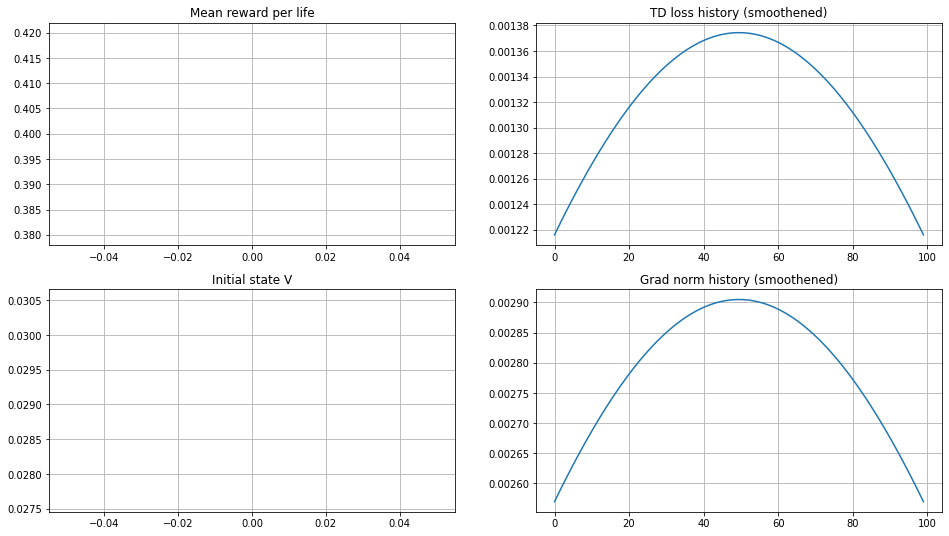

  0%|          | 3279/1000001 [06:57<35:16:02,  7.85it/s]


KeyboardInterrupt: 

In [17]:
state = env.reset()
beta_diff = (1 - exp_replay.beta) /  total_steps

with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
        _, state = play_and_record(state, agent, target_network, env, exp_replay, timesteps_per_epoch)
        batch = exp_replay.sample(batch_size)
        loss = compute_td_loss(*batch, agent = agent, target_network=target_network)
        loss.backward()
        
        if USE_PRIORITIEZED_BUFFER:
            exp_replay.beta += beta_diff

        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm.cpu())

        if step % refresh_target_network_freq == 0:
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(clip_rewards=False, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()
        if step and step % 10**5 == 0:
            torch.save(
            {
                'agent_state_dict': agent.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'mean_rw_history': mean_rw_history,
                'td_loss_history': td_loss_history,
                'grad_norm_history': grad_norm_history,
                'initial_state_v_history': initial_state_v_history,
                'step': step                     
            },
                os.path.join('checkpoints', f'model_step_{step}.pt'),
            )

In [ ]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
)
print('final score:', final_score)

In [ ]:
def patch_render(env):
    env.metadata['render.modes'] = ['rgb_array']
    return env

In [ ]:
gym.logger.set_level(gym.logger.DEBUG)
with gym.wrappers.Monitor(patch_render(make_env()), directory="videos", force=True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]

In [ ]:
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

In [ ]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()